In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv("eda_data.csv")

In [6]:
# choose relevant columns
df.columns

df_model = df[
    [
        "avg_salary",
        "Rating",
        "Size",
        "Type of ownership",
        "Industry",
        "Sector",
        "Revenue",
        "num_comp",
        "hourly",
        "employer_provided",
        "job_state",
        "same_state",
        "age",
        "python_yn",
        "spark",
        "aws",
        "excel",
        "job_simp",
        "seniority",
        "desc_len",
    ]
]

In [7]:
# get dummy data
df_dum = pd.get_dummies(df_model)

## Model Training

In [8]:
# train test split
from sklearn.model_selection import train_test_split

In [9]:
X = df_dum.drop("avg_salary", axis=1)
y = df_dum.avg_salary.values

#80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  
)

### 1. Ordinary Least Squares (OLS) Regression Model

In [11]:
# multiple linear regression
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     10.21
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           1.47e-94
Time:                        19:15:39   Log-Likelihood:                -3311.6
No. Observations:                 742   AIC:                             6909.
Df Residuals:                     599   BIC:                             7568.
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                43.6206      6.718      6.493      0.000      30.427      56.814
Rating                                                3.6072      1.937      1.862      0.063      -0.197       7.412
num_comp                                              2.2503      0.868      2.592      0.010       0.545       3.955
hourly                                              -36.5646      9.173     -3.986      0.000     -54.580     -18.549
employer_provided                                    31.3732     11.524      2.722      0.007       8.741      54.006
same_state                                            2.4864      2.619      0.949      0.343      -2.657       7.629
age                                                   0.0352      0.030      1.172      0.242      -0.024       0.094
python_yn                                             8.1375      2.523      3.225      0.001       3.182      13.093
spark                                                -0.5710      2.920     -0.196      0.845      -6.307       5.165
aws                                                   1.1218      2.736      0.410      0.682      -4.251       6.495
excel                                                -0.4049      2.268     -0.179      0.858      -4.858       4.049
desc_len                                             -0.0001      0.001     -0.171      0.864      -0.002       0.001
Size_-1                                              13.6113      8.629      1.577      0.115      -3.335      30.558
Size_1 to 50 employees                                1.1067      6.501      0.170      0.865     -11.660      13.874
Size_10000+ employees                                -2.8817      5.800     -0.497      0.619     -14.272       8.509
Size_1001 to 5000 employees                           6.1362      3.878      1.582      0.114      -1.481      13.753
Size_201 to 500 employees                             2.2568      3.873      0.583      0.560      -5.350       9.864
Size_5001 to 10000 employees                         -3.8766      5.440     -0.713      0.476     -14.561       6.808
Size_501 to 1000 employees                            2.1829      4.059      0.538      0.591      -5.790      10.155
Size_51 to 200 employees                              4.2001      4.422      0.950      0.343      -4.484      12.884
Size_Unknown                                         20.8850     13.992      1.493      0.136      -6.594      48.363
Type of ownership_-1                                 13.6113      8.629      1.577      0.115      -3.335      30.558
Type of ownership_College / University                6.4226     17.739      0.362      0.717     -28.415      41.260
Type of ownersh

### 2. Linear and Lasso Regression Model

In [12]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

#linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm, X_train, y_train, scoring="neg_mean_absolute_error", cv=3))

-51908185.00798432

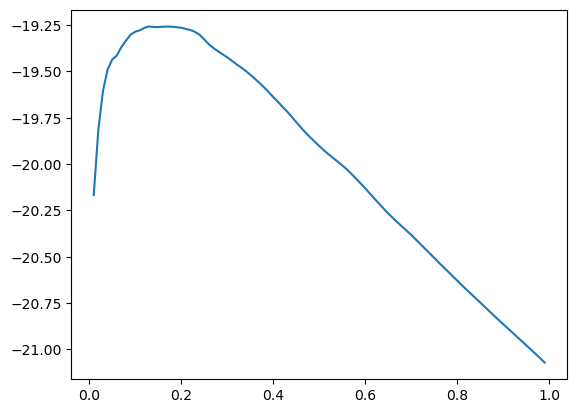

In [13]:
# lasso regression
lm_l = Lasso(alpha=0.13)
lm_l.fit(X_train, y_train)
np.mean(
    cross_val_score(lm_l, X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
)

#hyperparameter tuning for Lasso
alpha = []
error = []

for i in range(1, 100):
    alpha.append(i / 100)
    lml = Lasso(alpha=(i / 100))
    error.append(
        np.mean(
            cross_val_score(
                lml, X_train, y_train, scoring="neg_mean_absolute_error", cv=3
            )
        )
    )

plt.plot(alpha, error)

In [14]:
err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns=["alpha", "error"])
df_err[df_err.error == max(df_err.error)]

,alpha,error
12,0.13,-19.257798


### 3. Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

np.mean(cross_val_score(rf, X_train, y_train, scoring="neg_mean_absolute_error", cv=3))

-14.965064819087663

### Model Tuning using GridSearch CV


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators": range(10, 300, 10),
    "criterion": ("mse", "mae"),
    "max_features": ("auto", "sqrt", "log2"),
}

gs = GridSearchCV(rf, parameters, scoring="neg_mean_absolute_error", cv=3)
gs.fit(X_train, y_train)

gs.best_score_
gs.best_estimator_

## Model Evaluation

In [17]:
#Predictions on the test set
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

#Calculating MAE for each model
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, tpred_lm)
mean_absolute_error(y_test, tpred_lml)
mean_absolute_error(y_test, tpred_rf)

lm_mae = mean_absolute_error(y_test, tpred_lm)
lasso_mae =  mean_absolute_error(y_test, tpred_lml)
rf_mae =  mean_absolute_error(y_test, tpred_rf)

print(f'Linear Regression MAE: {lm_mae}')
print(f'Lasso Regression MAE: {lasso_mae}')
print(f'Random Forest MAE: {rf_mae}')


Linear Regression MAE: 18.85518999021409
Lasso Regression MAE: 19.665303712749914
Random Forest MAE: 11.108480780964003


### Saving the best model

In [18]:
# Ensemble Prediction (Average of Linear Regression and Random Forest):
mean_absolute_error(y_test, (tpred_lm + tpred_rf) / 2)

# Saving the best model using Pickle
import pickle

pickl = {"model": gs.best_estimator_}
pickle.dump(pickl, open("model_file" + ".p", "wb")) #binary write mode

#Loading the Model and Making a Prediction:
file_name = "model_file.p"
with open(file_name, "rb") as pickled:
    data = pickle.load(pickled)
    model = data["model"]

model.predict(np.array(list(X_test.iloc[1, :])).reshape(1, -1))[0]

list(X_test.iloc[1, :])

/Users/shalmolymondal/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[3.6,
 0.0,
 0.0,
 0.0,
 1.0,
 34.0,
 0.0,
 0.0,
 0.0,
 1.0,
 4608.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


## Visualization

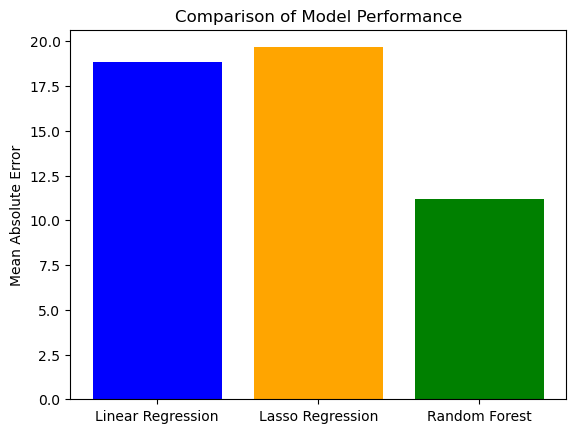

In [19]:
# Created a bar plot to compare MAE
models = ['Linear Regression', 'Lasso Regression', 'Random Forest']
mae_values = [lm_mae, lasso_mae, rf_mae]

plt.bar(models, mae_values, color=['blue', 'orange', 'green'])
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Model Performance')
plt.show()


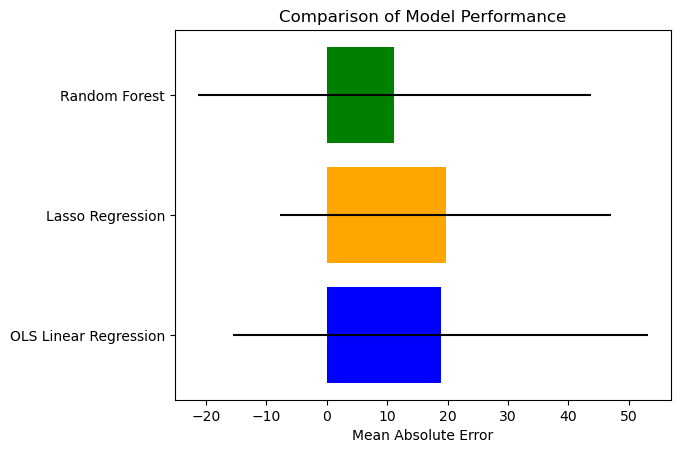

In [29]:
import matplotlib.pyplot as plt
import numpy as np

models = ['OLS Linear Regression', 'Lasso Regression', 'Random Forest']
mae_values = [lm_mae, lasso_mae, rf_mae]
std_errors = [np.std(tpred_lm), np.std(tpred_lml), np.std(tpred_rf)]

plt.barh(models, mae_values, xerr=std_errors, color=['blue', 'orange', 'green'])
plt.xlabel('Mean Absolute Error')
plt.title('Comparison of Model Performance')
plt.show()


In [22]:


models = ['Linear Regression', 'Lasso Regression', 'Random Forest']
mae_values = [lm_mae, lasso_mae, rf_mae]

# Create a DataFrame for the tabular summary
summary_df = pd.DataFrame({
    'Model': models,
    'Mean Absolute Error': mae_values
})

# Display the table
print(summary_df)


               Model  Mean Absolute Error
0  Linear Regression            18.855190
1   Lasso Regression            19.665304
2      Random Forest            11.190821
